In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [60]:
X_test = X[0:15]*255
X_test = X_test.astype('uint8')

## Histogram Equalization for Color Images

Histogram equalization enhances the contrast of an image by redistributing pixel intensity values to cover the entire possible range (0–255 for an 8-bit image). This can be particularly useful for images that are too dark, too bright, or low contrast, where details may be hard to see.

### 1. What is Histogram Equalization?
Histogram equalization works by adjusting the image so that its intensity histogram (a plot of pixel intensity values) becomes more evenly distributed across all possible values. In a low-contrast image, intensity values are often clustered in a narrow range. Histogram equalization spreads these values more evenly across the spectrum, which enhances contrast.

- **Standard Histogram Equalization**: Typically applied to grayscale images by stretching and redistributing pixel intensities.
- **Color Histogram Equalization**: Applied to the luminance channel (Y channel) in the YCrCb color space for color images. This way, color balance is preserved while enhancing contrast.

### 2. Why Use Histogram Equalization?
Histogram equalization is helpful when:

- **Images Have Low Contrast**: It makes details more visible by expanding the range of pixel intensities.
- **Uneven Illumination**: It can help normalize brightness, so shadowed or dark areas appear clearer, which is valuable for gesture recognition tasks.
- **More Consistent Features**: For machine learning models, histogram equalization can standardize images, reducing the impact of varied lighting across a dataset.

### 3. Applications in Gesture Recognition
In gesture recognition, histogram equalization helps:

- **Enhance Hand and Finger Details**: By bringing out subtle features in the hand shape or finger positions, it makes the gesture more distinguishable.
- **Improve Edge Detection and Segmentation**: Contrast-enhanced images allow edge detectors and segmentation algorithms to perform better.
- **Handle Lighting Variations**: When gestures are performed in different lighting, equalization makes the images more consistent for a recognition model.

In [62]:
def equalize_histogram_color(image):
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    # Convert Y channel to uint8 if necessary and equalize it
    y_channel = ycrcb[:, :, 0]
    ycrcb[:, :, 0] = cv2.equalizeHist(y_channel)
    
    # Convert back to BGR
    return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)

# Apply to all images
X_equalized = np.array([equalize_histogram_color(img) for img in X_test])

## Edge Detection: Canny
The Canny edge detector is a popular and powerful algorithm for detecting edges in images. It’s widely used because of its accuracy in capturing important structural outlines, like the edges of objects, while minimizing noise and irrelevant details. 

### 1. What is the Canny Edge Detector?
The Canny edge detector is a multi-step process that aims to detect edges, or boundaries between different regions in an image, by identifying areas of rapid intensity change. It was developed by John Canny in 1986, and the method has remained one of the most effective edge detection techniques. Canny edge detection consists of these key steps:

- **Noise Reduction**: The image is first smoothed using a Gaussian filter to reduce noise, which can cause false edges.
- **Gradient Calculation**: The algorithm calculates the intensity gradient of the image, typically using Sobel operators. This step identifies regions where intensity changes sharply, which usually corresponds to edges.
- **Non-Maximum Suppression**: This step keeps only the local maxima in the gradient image, thinning the edges to a single pixel width for cleaner results.
- **Double Thresholding and Edge Tracking by Hysteresis**: The algorithm applies two thresholds: a high threshold to identify strong edges and a lower one for weaker edges. Only edges connected to strong edges are kept, which reduces noise and connects broken edges.

### 2. Why Use Canny Edge Detection?
Canny edge detection is particularly useful because it:

- **Accurately Locates Edges**: By focusing on strong intensity gradients, it finds real edges effectively while ignoring weaker gradients caused by noise.
- **Minimizes False Detections**: The double thresholding technique helps in eliminating false edges, making the detected edges more reliable.
- **Produces Thin and Continuous Edges**: The non-maximum suppression step thins edges to a single-pixel width, and edge tracking by hysteresis ensures continuity, which is useful for preserving the shapes of objects in the image.

### 3. Applications in Gesture Recognition
In tasks like sign language gesture recognition, edges play a crucial role because:

- **Edges Define Hand Shape**: Outlines of hands and fingers are essential features for identifying specific gestures.
- **Noise Reduction**: Canny reduces the impact of shadows or lighting changes by focusing on strong contours rather than minor intensity changes.
- **Efficiency in Processing**: Reducing the image to just the edge pixels reduces the amount of data processed by later stages in a recognition pipeline, making algorithms more efficient.

In [69]:
def canny_edge_detection_color(image, low_threshold=50, high_threshold=150):
    # Convert to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    return cv2.Canny(gray_image, low_threshold, high_threshold)

# Apply to all images
X_edged = np.array([canny_edge_detection_color(img) for img in X_equalized])

## Adaptive Thresholding
Adaptive thresholding is another effective preprocessing technique used to segment an image, especially when lighting or background conditions vary across different regions of the image. Unlike standard thresholding, which uses a single global threshold value, adaptive thresholding determines the threshold dynamically for smaller regions of the image. This makes it highly valuable for processing complex images where a uniform threshold would fail to capture meaningful detail.

### 1. What is Adaptive Thresholding?
Adaptive thresholding divides the image into small regions and calculates the threshold separately for each region based on local pixel intensities. The algorithm essentially creates a custom threshold value for each part of the image. This helps in isolating regions of interest, like a hand gesture, even when there are variations in lighting or shadows across the image.

There are two common methods for adaptive thresholding:

- **Mean Adaptive Thresholding**: The threshold is set as the mean of the pixel values in the local neighborhood around each pixel.
- **Gaussian Adaptive Thresholding**: The threshold is set as a weighted sum (Gaussian-weighted) of the pixel values in the local neighborhood, which can help reduce the impact of noise.

### 2. Why Use Adaptive Thresholding?
Adaptive thresholding is beneficial for images with uneven lighting or complex backgrounds because it:

- **Handles Lighting Variations**: Since it applies a localized threshold, it works well even if parts of the image are under different lighting conditions. This is especially useful for hand gesture recognition, where the background might vary, or shadows may fall over parts of the hand.
- **Enhances Region Segmentation**: For tasks like isolating a hand from the background, adaptive thresholding can separate the gesture more effectively than a global threshold, especially if the hand is moving in front of a background with varying intensities.
- **Reduces Noise in Segmentation**: By focusing on local regions, adaptive thresholding reduces the influence of global intensity variations, making the segmentation cleaner and less noisy.

### 3. Applications in Gesture Recognition
For gesture recognition, adaptive thresholding is helpful in situations where:

- **Hands and Background Have Similar Intensities**: Adaptive thresholding can separate the hand from the background based on localized differences.
- **Complex Lighting and Shadows**: Since adaptive thresholding adjusts to local intensities, it’s more robust against shadows or uneven lighting that might otherwise obscure gesture contours.

In [70]:
def adaptive_thresholding_color(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Ensure the image is in uint8 format
    return cv2.adaptiveThreshold(
        gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

# Apply to all images
X_segmented = np.array([adaptive_thresholding_color(img) for img in X_equalized])

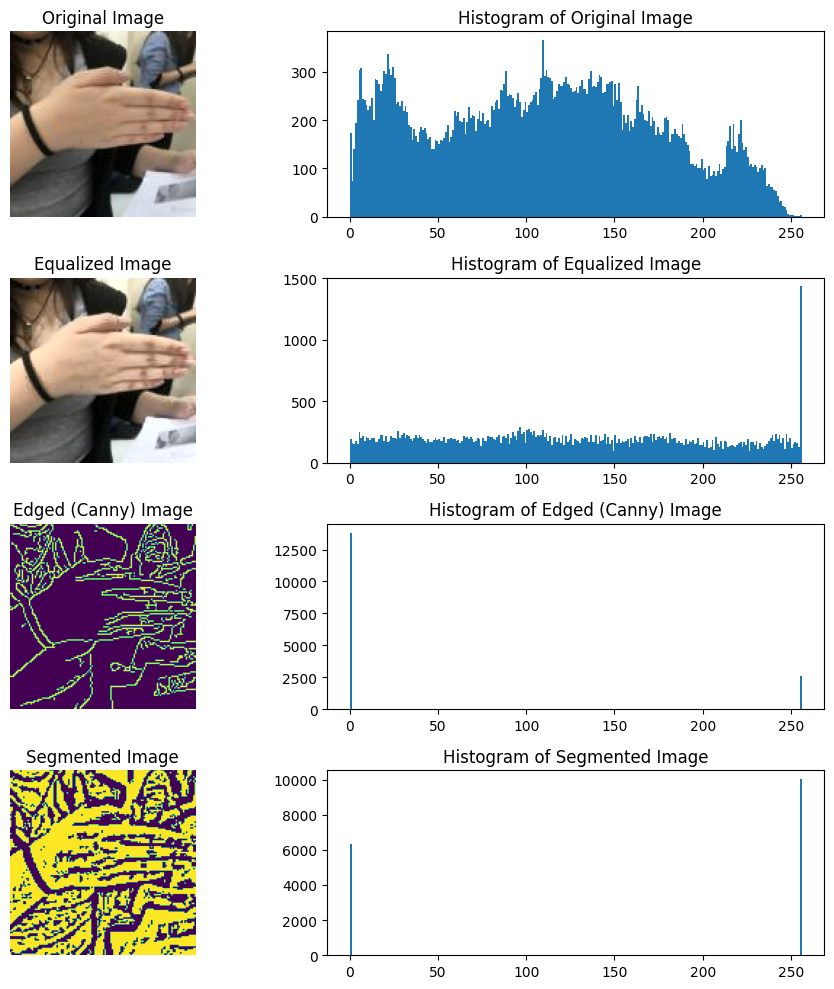

In [79]:
import matplotlib.pyplot as plt

# Assume `original_image` is one image from X and `equalized_image` is the corresponding image in X_equalized
idxIm = 0

# Plot original and equalized images
plt.figure(figsize=(10, 10))

# Original image and its histogram
plt.subplot(4, 2, 1)
plt.imshow(X_test[idxIm])
plt.title("Original Image")
plt.axis('off')

plt.subplot(4, 2, 2)
plt.hist(X_test[idxIm].ravel(), 256, [0, 256])
plt.title("Histogram of Original Image")

# Equalized image and its histogram
plt.subplot(4, 2, 3)
plt.imshow(X_equalized[idxIm])
plt.title("Equalized Image")
plt.axis('off')

plt.subplot(4, 2, 4)
plt.hist(X_equalized[idxIm].ravel(), 256, [0, 256])
plt.title("Histogram of Equalized Image")

# Edged image and its histogram
plt.subplot(4, 2, 5)
plt.imshow(X_edged[idxIm])
plt.title("Edged (Canny) Image")
plt.axis('off')

plt.subplot(4, 2, 6)
plt.hist(X_edged[idxIm].ravel(), 256, [0, 256])
plt.title("Histogram of Edged (Canny) Image")

# Segmented image and its histogram
plt.subplot(4, 2, 7)
plt.imshow(X_segmented[idxIm])
plt.title("Segmented Image")
plt.axis('off')

plt.subplot(4, 2, 8)
plt.hist(X_segmented[idxIm].ravel(), 256, [0, 256])
plt.title("Histogram of Segmented Image")

plt.tight_layout()
plt.show()